In [579]:
import numpy as np
import math

from scipy.stats import norm
from scipy import interpolate

import matplotlib.pyplot as plt

## Calculate zero coupon rates and discount factors.

We calculate the zero coupon rates and their discount factors, in order to calculate the forwards and the present values of the defined swaption and its underlying swap.
### Calculate discount factors.  
We calculate the discount factors from pre-defined market rates and with formulas depending on the nature of the instrument.

- $DF(T_0) = \frac{1}{1+\delta_0 . S(T_0)}$ $ \Rightarrow $ at the 1st day    
$ \Rightarrow $ a 1-day deposit starts 1 day later, so we add 1 day to the period of interests.   
$ \Rightarrow $ we use the corresponding discount factor as baseline for calculation of following discount factors

- $DF(T_n) = \frac{DF(T_0)}{1+\delta_N . S(T_n)}  \Rightarrow $ when rate got from a deposit

- $DF(T_n) = \frac{DF(T_0) - S(T_n) \sum_{i=1}^{n} \delta_i DF(T_i)}{1+\delta_n . S(T_n)} \Rightarrow $ when rate got from a swap

More information available in the project **price_multicurve_for_vanilla_swap_cap_floor_swaption** in part *Calculate the OIS Zero Coupon*.

### Calculate zero coupon rates.
We calculate the zero coupon rates from the discount factors previously calculated.

- $DF(t) = \frac{1}{(1+z)^t}$

We interpolate the calculated zero coupon rates over the defined maturities.

### Calculate discount factor on-demand.
Thanks to the zero coupon rate curve, we can calculate the discount factor at any time *t*.

- $DF(t) = e^{-z(t)t}$

Nevertheless we apply a lognormal interpolation of the discount factors so that we get later on, a regular forward curve.    
We want a regular forward curve, because we will use the Monte Carlo method with simulation of the forward curve and we want to avoid extrem or negative values causing the simulation of forwards to crash.

In [580]:
"""
Zero-coupon curve
"""
class zc_curve :

	def __init__(self, deposit_market, swap_market):
		market_rates = sorted(deposit_market + swap_market, key=lambda x: x[0])
		maturities, rates = zip(*market_rates)
		maturities = np.array(maturities)
		rates = np.array(rates)

		rates = interpolate.interp1d(maturities, rates, bounds_error=False, fill_value="extrapolate")
		
		zc_rates = np.zeros(len(maturities))
		
		# Calculation of the rates into zero coupon rate
		zc_discount_0 = 0.0  # Initialize the discount factor for the first maturity
		zc_discount = 0.0  # Initialize the discount factor
		sum_discount_x_fraction = 0.0  # Initialize the sum of discount factors multiplied by fraction of the year
		
        # The first maturity is 1 day on a 360 days-based, and we assume the €ster rate for this maturity
		zc_discount_0 = 1 / (1 + rates(maturities[0]) * maturities[0] * 365/360) # Discount factor for the first maturity
		zc_rates[0] = (1 / zc_discount_0 ** (1 / maturities[0])) - 1  # Zero-coupon rate for the first maturity
		
		for i in range(1, len(maturities)):
			# The ZC rates from deposit (with maturity up to 1 year) are directly calculated based on fraction of the year (on 360 days-based) and the discount factor \
            # of the start date which is 1 day on a 360 days-based
			if maturities[i] <= 1:
				zc_discount = zc_discount_0 / (1 + rates(maturities[i]) * maturities[i] * 365/360)
				zc_rates[i] = (1 / zc_discount) ** (1 / maturities[i]) - 1 # Zero-coupon rate for the current maturity (up to 1 year)
				sum_discount_x_fraction = zc_discount * maturities[i] * 365/360 
				
			else:
		    # The ZC rates from swap (with maturity higher than 1 year) are calculated based on previous discount factors and their corresponding fraction of the year \
            # between 2 calculated discount factors (on 360 days-based)
				zc_discount = (zc_discount_0 - rates(maturities[i]) * sum_discount_x_fraction) / (1 + rates(maturities[i]) * (maturities[i] - maturities[i-1]) * 365/360)
				zc_rates[i] = (1 / zc_discount) ** (1 / maturities[i]) - 1
				sum_discount_x_fraction += zc_discount * (maturities[i] - maturities[i-1]) * 365/360
		
		self.maturities = maturities
		self.zc_rates = zc_rates
		self.zc_rates_interp = interpolate.interp1d(maturities, zc_rates, bounds_error=False, fill_value="extrapolate")


	def df(self, t):
		t = np.atleast_1d(t)
		log_df_nodes = -self.zc_rates * self.maturities
		
		if np.isscalar(t):
			t = np.array([t])
		else:
			t = np.asarray(t)
			
		# interpolation "log_df"
		log_df_interp = np.interp(
        	t, 
        	self.maturities, 
        	log_df_nodes,
        	left=log_df_nodes[0], # left extrapolation
        	right=None             
    	)
		
		# right extrapolation: flat-zero = pente du dernier segment
		slope = (log_df_nodes[-1] - log_df_nodes[-2]) / (self.maturities[-1] - self.maturities[-2])
		beyond = t > self.maturities[-1]
		log_df_interp[beyond] = log_df_nodes[-1] + slope * (t[beyond] - self.maturities[-1])
	
		return np.exp(log_df_interp).item() if np.exp(log_df_interp).size == 1 else np.exp(log_df_interp)

### Plot the rates curves.

We plot the zero-coupon rate curve and the forward 6M rate curve to give an overview of the evolution of the rates.

In [581]:

def plot_curve(maturities, rates, title_graph):
    """ Plot a curve of rates over a specified maturity range. """
		
    # Generate dates for plotting
    plot_maturities = np.arange(0, maturities[-1])
		
	# Plotting the curves
    plt.figure(figsize=(10, 5))
    plt.plot(plot_maturities, rates(plot_maturities), label = title_graph, color='blue')
    if title_graph == 'Interest Rate Curves':
        plt.scatter(maturities, rates(maturities), color='red', marker='x', label='original rates')
    plt.title(title_graph)
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rate')
    plt.grid()
    plt.legend()
    plt.show()	

## Calculate the forward swap rate of the underlying swap.  

$S(t, T_s, T_p) = \frac{B(t,T_s) - B(t, T_p)}{LVL}$.  
*where*:   
- $B(t,T_s)$ the start date's discount factor. 
- $B(t,T_p)$ the payment (i.e. end) date's discount factor. 
- $LVL(T_n) = \sum_{i=1}^{n} \delta_i DF(T_i)$ *with* $DF(T_i)$ the discount factors for each forward 6M

The forward swap rate calculated here is the rate where the swap's value is 0 at initiation.   

In [582]:
class swap :

    def __init__(self, payer_receiver, expiry, swap_tenor, fwd_tenor):
        self.payer_receiver = payer_receiver
        self.expiry = expiry
        self.swap_tenor = swap_tenor
        self.fwd_tenor = fwd_tenor

    # Calculate the forward swap rate of the swaption's underlying
    def forward_swap_rate(self, df):   
        self.n_pay = int(round(self.swap_tenor / self.fwd_tenor)) # number of payments in the swap
        start_time = self.expiry + 2./365.
        payment_times = [start_time + (i+1) * self.fwd_tenor for i in range(self.n_pay)]
        level = sum(self.fwd_tenor * float(df(t)) for t in payment_times)

        self.F_swap = (df(start_time) - df(payment_times[-1])) / level
        self.level = level

## Define and calibrate the Libor Market Model (LMM).

**Libor Market Model** $ \Rightarrow \boxed{dL_i(t) = \mu_i(t, L(t)) dt + \sigma_i(t) L_i(t) dW_i(t)} $

*where*:  
$L(t)$ the forward rate.    
$\mu_i(t, L(t))$ the drift of the forward rate.      
$\sigma_i(t)$ the volatility of the forward rate.  
$dW_i(t)$ the brownian movement with $\mathbb{E}[dW_i dW_j] = \rho_{ij} dt$ *where* $\rho$ the coefficient of correlation of the forwards with each other.   
***
### Calculate the forwards.

We calculate the forwards based on the zero coupon rates previously calculated.    

N.B. We apply here a single-curve method.   
Multi-curve method also possible, and described in the project **pricer_multicurve_for_vanilla_swap_cap_floor_swaption** in the part *Calculate the forward EURIBOR 6M curve*.

$L(t, T_1, T_2) = (\frac{B(T_1)}{B(T_2)} - 1) * \frac{1}{\delta} $

*where*:  
$B(T_1) = DF(T_1)$ the discount factor at the start date of the forward.  
$B(T_2) = DF(T_2)$ the discount factor at the payment/end date of the forward.     
$\delta$ the time period between $T_1$ and $T_2$

Because we will use a forward 6M, we calculate a forward rate at every 6 months, and interpolate them.
***
### Calculate the volatility structure.

Normally we use market volatilities observed for swaptions in order to calibrate the model, so that we get a surface of impled volatilities.   
Such method in the calculation of volatilities based on swaption's price, is done in the project **pricer_local_vol_for_options** in part *Calculate implied volatilities from the SABR model*.    

But here we simply calculate ATM volatilities function of the maturity only, with an empirical method used in the calibration of LMM : $\sigma_i(T) = \big(a + b (T_i - t)\big) e^{-c (T_i - t)} + d$.  
 
*where*:   
$T$ the maturity of the forward.  
$a$ the short term volatility initial level.  
$b$ the coefficient controlling how volatility increases when maturity increases.  
$c$ the coefficient controlling how volatility decreases for the longest maturities.  
$d$ the coefficient controlling that the long-term volatility is not 0. 
***
### Identify and measure the factors of variance.
In order to simulate the forwards' trajectories later with the Monte Carlo method, we identify the most significant factors explaining the variances of the forwards:    

- $dW_i(t) = \sum_{k=1}^F \lambda_{ik} \, dZ_k(t)$ the dynamic of the brownian movement of the Libor Market Model, function of Gaussian variables, each corresponding to a factor.  

*where*:   
$F$  the number of factors $\ll N$ (compared to the number of correlations from the matrix).  
$Z_k$ the independant brownian movements.  
$\lambda_{ik} $ the factor loadings.   

First we calculate the matrix of correlation of the forwards between each other, i.e. we get $\frac{N * N}{2} - 1$ correlations.    
Second we identify the 3 most significant factors using the PCA reduction method on the correlation matrix.

#### 1. Calculate the matrix of correlation.
Similarly to the volatility structure, we calculate the correlations based on a simple formula $\rho_{ij} = \exp\big(-\beta |T_i - T_j|\big)$ (the closer the forwards are, the more correlated they are).   
*i.e.*:     
$\beta > 0 $    
$\Rightarrow $  when $|T_i - T_j| \to 0, \rho_{ij} \to 1$.   
$\Rightarrow $  when $|T_i - T_j| \to \infty, \rho_{ij} \to 0$.   

For example, correlations explain the lower volatility for a long swaption compared to the sum of its elementary volatilities.    
CMS (constant maturity swaps) depend on these correlations too (as later seen). 

#### 2. Identify and measure the 3 majors factors explaining the variance of the forwards.
We identify only 3 factors as they explain most of the variance of the forwards :
- Factor 1 - level : parallel shift of the forwards
- Factor 2 - slope : upward/downward shift of the forwards
- Factor 3 - curvature : instant rate of shift of the forwards

As well, restricting the correlations between forwards to 3 factors will help to simulate the forwards with the Monte Carlo method later on.   

We identify these 3 factors with the PCA (principal components analysis) reduction method, used on the matrix of correlation.   

In the script, we use the function *np.linalg.eigh* calculating eigenvalues and eigenvectors of the matrix, and keep the 3 highest values for the eigenvalues and their eigenvectors.   
The PCA reduction breaks down the matrix according to the formula $\rho = Q \Lambda Q^\top$.   
*where*:   
$\rho$ the matrix of correlations.   
$Q$ the matrix of the eigenvectors  $\Rightarrow $  principal directions.   
$\Lambda$ the diagonal matrix of the eigenvalues $\Rightarrow $ explaining the variance

Finally we measure the factor loadings used later in simulating the forwards.
The factor loadings indicate how the deformation of the curve for each forward maturity occurs.        
The number of factor loadings corresponds to the number of defined forwards x the number of factors.     
Based on the 3 factors defined earlier, we can interpret the evolution of these factors loadings along the forwards:
- Factor 1 - level : factor loadings are positive and constant
- Factor 2 - slope : factor loadings are positive in the short term, and negative in the long term
- Factor 3 - curvature : factor loadings are positive in the extrems, and negative in the centre

*N.B.* In order to simulate the forwards' trajectories and therefore their brownian movements, we could have used as many Gaussian variables as we have correlations, i.e. for each forward a correlation with each other forward.      
We would have used the Cholesky decomposition.    
But as mentioned earlier, later when using the Monte Carlo method, we would have had too many variables to consider, increasing significantly the calculation of the forwards' values.    
Therefore the 3 factors listed before are sufficient.      


In [583]:
class libor_market_model :

    def __init__(self, swap) :
        self.swap = swap
        
        
    def forward_curve(self, df):
        self.maturities = np.arange(self.swap.fwd_tenor, zc_curve.maturities[-1] + self.swap.fwd_tenor, self.swap.fwd_tenor)
        self.forward_rates = np.zeros(len(self.maturities))  

        start_times = np.arange(len(self.maturities)) + 2.0 / 365.0
        pay_times = start_times + swap.fwd_tenor
        df_start = df(start_times)
        df_pay = df(pay_times)
        self.forward_rates = ((df_start / df_pay) - 1.0) / self.swap.fwd_tenor

        self.forward_rates_interp = interpolate.interp1d(self.maturities, self.forward_rates, bounds_error=False, fill_value="extrapolate")
        
        
    def volatility_structure(self, a, b, c):
        maturities = np.asarray(self.maturities)
        self.sigmas = (a + b * maturities) * np.exp(-c * maturities)
        
        self.sigmas = np.clip(self.sigmas, 1e-8, 0.5)


    def correlation_factors(self, beta):
        maturities = np.asarray(self.maturities)
        diff = np.abs(maturities[:, None] - maturities[None, :]) #symetric matrix (N,N) 
        corr_matrix = np.exp(-beta * diff)                       #ymetric matrix (N,N) simulating the correlation between each forward

        self.corr_matrix = corr_matrix                           #(N,N)
        
        eigvals, eigvecs = np.linalg.eigh(corr_matrix)           #calculation of eigenvalues and eigenvectors (by default sort from the lowest to the highest)
        idx = eigvals.argsort()[::-1]                            #inversion of the indexes ==> eigenvalues from the highest to the lowest
        eigvals = eigvals[idx]; eigvecs = eigvecs[:,idx]    

        F = 3
        eigvals_F = eigvals[:F]                                  #(F)
        eigvecs_F = eigvecs[:,:F]                                #(N,F)
        self.factor_loadings = eigvecs_F * np.sqrt(eigvals_F)    #(N,F)
        self.F = F

## Calculate the price of a swaption using the Libor Market Model with Monte Carlo method.

### What is a swaption and why a swaption?
A swaption is an instrument giving the right to enter a swap.    
For instance, a payer swaption's owner has the right to enter a swap at a future time where the owner pays a fixed amount, and receives a floating amount.   

A swaption, similar to an option, is used as a hedge against the risk of Cash-Flow or the risk of MTM.   
For example, next year an investor should pay a monthly floating amount, whose amount depends on a market's rate.    
The investor enters a payer swaption with maturity 1 year to avoid the risk of paying too much if the market's rate goes up.    
One year later, if the market's rate is higher than anticipated, the investor enters the swap (based on pre-defined conditions) to pay a fixed amount and receive a floating amount.  
The floating amount received from the new swap hedges the original floating amount to be paid.

****
### Calculate the drift $\mu^{T_n}_i$ of the forwards corresponding to the terminal measure $\mathbb{Q}^{T_n}$.
In order to calculate the price of the swaption, we simulate the dynamic of the forwards.   
We use $B(t,T_n)$ as numeraire, as we can simulate every forward with this unique numeraire.        
From there, we calculate the new drift $\mu_i^{T_n}$ with the terminal measure $\mathbb{Q}^{T_n}$, measure for the dynamic of the complete set of forwards. 

The drift $\mu_i^{T_n}(t)$ under the terminal measure $\mathbb{Q}^{T_n}$ is $\mu_i^{T_n}(t)=\sum^{j>i} \,\delta\, \sigma_i(t)\, \sigma_j(t)\, \rho_{ij}\,\frac{L_j(t)}{1+\delta L_j(t)}$.  
*where*:   
$\delta$ the period of time of a forward i.e. 6 months for a forward 6M.  
$L_i(t)$ and $L_j(t)$ both forwards, with $L_j(t)$ coming after $L_i(t)$.   
$\sigma_i(t)$ and $\sigma_j(t)$ the instant volatilities of the forward $L_i(t)$ and $L_j(t)$.   
$\Rightarrow \delta\, \sigma_i(t)\, \sigma_j(t)\, \rho_{ij}$ is the interaction between volatility of $L_i(t)$ and volatilities of following $L_j(t)$.    

Here are the major steps to get the formula of $\mu_i^{T_n}(t)$ under the terminal measure $\mathbb{Q}^{T_n}$ :  

1. We do a change of measure, from $\mathbb{Q}^{T_n}$ to $\mathbb{Q}^{T_{i+1}}$ with its density $H_t = \frac{B(t,T_{i+1})}{B(t,T_n)} = \prod_{j=i+1}^{n-1} 1+\delta L_j(t) $ where $\frac{B(t,T_j)}{B(t,T_{j+1})} = \frac{1}{1+\delta L_j(t)}$.   
Under the forward measure $\mathbb{Q}^{T_{i+1}}$ i.e. the measure for each separate forward, the drift $\mu^{T_{t+1}}$ is 0 $\Rightarrow dL_i(t) = L_i(t)\,{\sigma}_i(t) dW^{\mathbb{Q}^{T_{i+1}}}_i(t) \Rightarrow$ martingale.      

2. From $\ln H_t = \sum_{j=i+1}^{n-1} \ln(1+\delta L_j(t))$ (simple transformation from the formula above), we apply Ito and keep the stochastic part.  
we get $\frac{dH_t}{H_t}\Big|{dW} = \sum_{j>i} \frac{\delta L_j(t)\sigma_j(t)}{1+\delta L_j(t)}\,dW^{\mathbb{Q}^{T_{i+1}}}_j(t)$.  

3. We then apply the theorem of Girsanov going from the forward measure $\mathbb{Q}^{T_{i+1}}$, to the terminal measure $\mathbb{Q}^{T_n}$ with its density proportional to $H_t$:   
$dW_k^{T_n}(t) = dW_k^{T_{i+1}}(t) + \lambda_k(t)dt$  with  $\lambda_i(t)= \sum_{j>i} \frac{\delta L_j(t)\sigma_j(t)}{1+\delta L_j(t)} \rho_{ij}$. 

4. By substituting $\lambda_i(t)$ in the equation of the dynamic $dL_i(t)$, we identify the new $\mu_i^{T_n}$ :   
$\mu_i^{T_n}(t)=\sum^{j>i} \,\delta\, \sigma_i(t)\, \sigma_j(t)\, \rho_{ij}\,\frac{L_j(t)}{1+\delta L_j(t)}$

5. Because we want to sum $\delta\, \sigma_i(t)\, \sigma_j(t)\, \rho_{ij}$ only when $j > i$, we use a mask to the calculated matrix where values from positions $i > j$ are ones.  

So we get the new dynamic of the forward under the terminal measure $\mathbb{Q}^{T_n}$ $dL_i(t) = \mu_i^{T_n}(t) L_i(t) + \sigma_i(t) L_i(t) dW_i^{\mathbb{Q}^{T_n}}(t) $.    

**** 
### Calculate the simulated prices of the CMS swap using a Gaussian variable for the stochastic process. 

In order to optimize the duration of the calculations in Monte Carlo:
- we split the number of simulation into smaller "batches" of simulations, processed one after another.  
- we consider the variable "Z" as antithetic, i.e. with a symmetry around 0, so that we reduce the variance and consequently we reduce the number of simulations with no degradation of the precision.   
- we calculate each brownian (1 brownian for 1 simulation) $dW$ based on the 3 factors previously calculated in *Identify and measure the 3 majors factors explaining the variance of the forwards*.   

#### 1. Simulate the forwards $L_i(t)$ using the lognormal Euler scheme.   
We iterate the dynamic of the forward $L_i(t)$ using the lognormal Euler scheme, until the expiration date of the swaption, i.e. the maturity date of the option, where the series *t* runs over the maturities initially defined with the market rates' instruments.      
$dL_i(t) = \mu_i(t) L_i(t)\, dt + \sigma_i L_i(t)\, dW_i(t) \quad  \boxed{\Rightarrow  L_i(t+\Delta t) \approx L_i(t)\, \exp\!\Big( (\mu_i - 0.5\sigma_i^2)\Delta t + \sigma_i \Delta W_i \Big)}$  *where* $\Delta W_i = dW\sqrt{\Delta t}$.    
We recalculate the drift $\mu_i^{T_n}(t)$ at each iteration based on the latest forwards.  
A Gaussian variable is used to simulate the brownian $dW_i^{\mathbb{Q}^{T_n}}(t)$. 

#### 2. Calculate the forwards $L_i(t)$ ' discount factors corresponding to each payment during the swap duration. 
$L(t, T_k, T_{k+1}) = (\frac{B(T_k)}{B(T_{k+1})} - 1) * \frac{1}{\delta_k} \Rightarrow B(t,T_{k+1})=\frac{B(t,T_k)}{1+\delta_k L(t, T_k, T_{k+1})}$.

*N.B.* In the script below, we use the function *cumprod* to calculate each discount factor with a multiplication of every previous forwards all together.  
Indeed $B(t, T_k) = \frac{1}{\prod_{j=\text{idx\_start}}^{k-1} (1 + \delta_k \, L_j)}$ where each new discount factor is the previous one divided by $(1 + \delta_k L_j)$.

#### 3. Calculate the present values of the floating leg and fixed leg of the swap.   

- $PV_\text{floating leg} = \Big(B(T_f, T_s) - B(T_f, T_{end})\Big)$

- $PV_\text{fixed leg} = S(0, T_s, T_p) \sum_{i=1}^{n}\delta_i B(T_f, T_i)$  *where* $S(0, T_s, T_p)$ is the swap rate at initiation.    

#### 4. Calculate the present value of the swap.   
$PV_\text{swap} = PV_\text{floating leg} - PV_\text{fixed leg}$

#### 5. Calculate the price of the swaption, actualized payoff under the terminal measure $\mathbb{Q}^{T_n}$ of the swaption.  
$\text{Payoff}_\text{swaption} = e^{-r_{T_f}T_f} Max(PV_\text{swap}, 0)$ *where* $T_f$ is the expiration date i.e. the option's maturity date.  

****

### Calculate the price of the swaption, from prices generated through Monte Carlo.
We calculate the price as the mean of the set of values calculated with Monte Carlo method, with its interval of confidence based on the standard deviation of the set of values.   


In [ ]:
class libor_market_model_swaption_mc:

    def __init__(self, Nsteps, Nsimul, batch_size, L0, swap, lmm, zc_curve, strike, dt) :
        self.Nsteps = int(Nsteps)                  # number of time periods
        self.Nsimul = int(Nsimul)                  # number of MC simulations
        self.batch_size = int(batch_size)          # number of MC simulations per calculation
        self.L0 = np.asarray(L0, dtype=float)      # forward curve's rates from t=0 to Tmax
        self.swap = swap                           # swap class (containing the swap's variables and functions)
        self.lmm = lmm                             # libor market model class (containing the lmm's variables and functions)
        self.zc_curve = zc_curve                   # zc_curve class (containing the zc_curve's variables and functions)
        self.strike = float(strike)    
        self.dt = float(dt)                        # period of time between each step

        # Pre-calculation of the indexes
        self.delta = float(self.swap.fwd_tenor)    # time period between 2 indexes
        self.idx_start = int(round(self.swap.expiry / self.delta)) # index of the swap's start date
        self.n_pay = int(round(self.swap.n_pay))   # number of payments in the swap
        self.idx_end = self.idx_start + self.n_pay # index of the swap's end date

        self.N = self.L0.shape[-1]                 # N = number of forwards

        # Pre-calculation of the drift mu under the terminal measure
        sigmas = self.lmm.sigmas.astype(float)
        sigma_prod = np.outer(sigmas, sigmas)                            # calculation of (vector(sigmas))^2 ==> matrix (N,N)
        delta_rho_sigma = self.delta * sigma_prod * self.lmm.corr_matrix # matrix (N,N)
        mask = np.triu(np.ones((self.N, self.N), dtype = float), k=1)    # generation of an upper triangle mask (position for "i <= j" = 0)
        self.DRS_masked = (delta_rho_sigma * mask).clip(-1e2, 1e2)       # application of the mask to the ARS matrix (coefficients for "i <= j" = 0) + boundaries

        factor_loadings = np.asarray(self.lmm.factor_loadings, dtype = float)
        self.factor_loadings = factor_loadings     # (N,F)


    def drifts_vectorized(self, L_batch):
        """
        Return mu: (m,N) or (N,).
        """   
        L = np.atleast_2d(np.asarray(L_batch, dtype=float))    # (m,N)
        denom = np.maximum(1.0 + self.delta * L, 1e-12)
        v = (L / denom).clip(-1e2, 1e2)
        mu = np.einsum("ik,jk->ij", v, self.DRS_masked)

        return mu[0] if np.ndim(L_batch) == 1 else mu
    

    def simulate_dW(self, m):
        """
        Return dW (m,N) = N(0, dt * corr) via factor loadings (N,F).
        """
        m_half = (m + 1) // 2
        Z = np.random.normal(size=(m_half, self.lmm.F))               
        Z_full = np.vstack([Z, -Z])[:m, :]   # we get Gaussian values for each simulated path m over the 3 factors ==> (m, F)

        # For each simulated path m we multiply the 3 Gaussian values (m,F), by the 3 factor loadings for each forward (N,F) 
        # ==> for each path and each forward (m, N), we have a brownian movement loaded with the 3 factors of variance identified in lmm.correlation_factors
        dW = np.einsum("ik,jk->ij", Z_full, self.factor_loadings) * np.sqrt(self.dt)  # eisum((m,F),(N,F)->(m, N))
    
        return dW
    

    def simulate_forward_batch(self, L0_batch):
        """
        Return L_paths: (m,N).
        """
        L_paths = L0_batch.copy()                      # (m,N)
        sigmas = self.lmm.sigmas.reshape(1, -1)        # (1,N)
        sigmas2 = (self.lmm.sigmas**2).reshape(1, -1 ) # (1,N)

        for _ in range(self.Nsteps):
            dW = self.simulate_dW(L_paths.shape[0])                 # (m,N)
            mu = self.drifts_vectorized(L_paths)                    # (m,N)
            exponent = (mu - 0.5 * sigmas2) * self.dt * dW * sigmas # (m,N)
            L_paths *= np.exp(exponent)                             # (m,N)

        return L_paths


    def payoff_swaption(self):
        """
        Return the payoffs, pv of the swap, and pv of the swap's floating and fixed legs
        """
        payoffs = np.zeros(self.Nsimul)
        pv_swap_paths = np.zeros(self.Nsimul)
        pv_float_paths = np.zeros(self.Nsimul)
        pv_fixed_paths = np.zeros(self.Nsimul)

        path_index = 0
        DF0_Topt = float(self.zc_curve.df(self.swap.expiry))

        while path_index < self.Nsimul:
            m = min(self.batch_size, self.Nsimul - path_index)              # number of simulations in the on-going batch to process

            L0_batch = np.broadcast_to(self.L0.reshape(1, -1), (m, self.N)) # (m,N)
            L_Topt = self.simulate_forward_batch(L0_batch)                  # (m,N)

            L_seg = L_Topt[:, self.idx_start:self.idx_end]                  # (m, n_pay)
            denom = 1.0 + self.delta * L_seg                                # (m, n_pay)
            DFt = 1.0 / np.cumprod(np.maximum(denom, 1e-12), axis=1)        # B(Topt,T_{k})

            DFt_end = DFt[:,-1]                                             # (m,)
            floating_t = 1.0 - DFt_end                                      # (m,)
            fixed_t = self.strike * self.delta * DFt.sum(axis=1)            # (m,)

            if self.swap.payer_receiver == 'payer':
                swap_t = floating_t - fixed_t
            else:
                swap_t = fixed_t - floating_t 

            swap_0 = swap_t * DF0_Topt                                      # (m,)
            payoff_0 = np.maximum(swap_t, 0.0) * DF0_Topt                   # (m,)

            payoffs[path_index:path_index+m] = payoff_0
            pv_swap_paths[path_index:path_index+m] = swap_0
            pv_float_paths[path_index:path_index+m] = floating_t * DF0_Topt
            pv_fixed_paths[path_index:path_index+m] = fixed_t * DF0_Topt

            path_index += m

        self.swaption_payoffs = payoffs
        self.pv_swap_paths = pv_swap_paths
        self.pv_float_paths = pv_float_paths
        self.pv_fixed_paths = pv_fixed_paths
        

    def compute_price_swaption(self) : # option_name, closed_form_price = -1, display=True
        self.payoff_swaption()
        mc_swaption_price = np.mean(self.swaption_payoffs)
        mc_swaption_std = np.std(self.swaption_payoffs)
        IClow = mc_swaption_price - 1.96 * mc_swaption_std / math.sqrt(self.Nsimul)
        ICup = mc_swaption_price + 1.96 * mc_swaption_std / math.sqrt(self.Nsimul)
        mc_swap_price = np.mean(self.pv_swap_paths)
        mc_float_value = np.mean(self.pv_float_paths)
        mc_fixed_value = np.mean(self.pv_fixed_paths)

        print(f"Monte Carlo Swap {self.swap.payer_receiver} {self.swap.expiry}y/{self.swap.swap_tenor}y with strike = {self.strike}")
        print(f"Underlying Swap price : %.8f" % (mc_swap_price))
        print(f"Underlying Swap's floating leg PV : %.8f" % (mc_float_value))
        print(f"Underlying Swap's fixed leg PV : %.8f" % (mc_fixed_value))
        print(f"Strike for Swap price = 0 : %.8f" % (self.swap.F_swap))
        print(f"Swaption price : {mc_swaption_price:.8f} 95% Confidence Interval: [{IClow:.4f}, {ICup:.4f}]")
        print("***---------------------------------------------------------------------------------------------------------------------------------------------------------------***")



## Calculate the price of a CMS swap using the Libor Market Model with Monte Carlo method.

### What is a CMS swap, why a CMS swap, and how does it work?
A CMS swap is an instrument for 2 counterparties to, regularly over a defined period, exchange a fixed amount against a floating amount based on a market long-term rate.     
The difference of a CMS swap with a regular swap is that: 
- the regular swap's floating leg is based on a market short-term rate such as the EURIBOR 6M.
- the CMS swap's floating leg is based on a market long-term rate such as the 10 years swap.

A CMS swap allows an investor to hedge against long-term rates.      
For example, an investor wants to hedge against a market rate's curve going upwards over the next 10 years (i.e. the long-term rates are higher than the short-term rates).   
The investor enters a receiver CMS swap where the reference swap has a 10 years duration.    
So the investor pays a fixed amount and receives a floating amount based on the 10 years swap's rate. 

A CMS swap works as following.     
The dates of exchange of cash are defined at the beginning of the contract.       
For each exchange, a date of fixing the floating rate is defined. At each of these fixing date, the reference swap rate is used.           
So for a 10 year swap used as a reference swap, the floating rate is the rate observed in the market for a 10 years swap.   

****
### Calculate the drift $\mu^{T_n}$ corresponding to the terminal measure $\mathbb{Q}^{T_n}$.
In order to calculate the price of the CMS swap, we simulate its dynamic.   
We use $B(t,T_p)$ as numeraire, as the payoffs are paid at $T_p$ and consequently $V(t)=B(t,T_p)\,\mathbb{E}^{\mathbb{Q}^{T_p}}\!\big[S(T_p;T_a,T_b)\,\big|\,\mathcal{F}_t\big]$ *where* $T_a$ and $T_b$ the start date and end date of the period.            

Nevertheless because we simulate the forwards here, not the interest rate's swap, then we have to consider the terminal measure $\mathbb{Q}^{T_n}$ and its drift $\mu_i^{T_n}$.   
So we calculate the new drift $\mu_i^{T_n}$ with the terminal measure $\mathbb{Q}^{T_n}$, measure for the dynamic of the complete set of forwards.     

We do a change of measure, from $\mathbb{Q}^{T_p}$ to $\mathbb{Q}^{T_n}$ with its density $H_t = \frac{B(t,T_n)}{B(t,T_p)}$.    
Because the measure of a forward is $\mathbb{Q}^{T_{i+1}}$ (not $\mathbb{Q}^{T_p}$), we have instead the density $H_t = \frac{B(t,T_n)}{B(t,T_{i+1})} = \frac{1}{\prod_{j=i+1}^{n-1} 1+\delta L_j(t)} $ where $\frac{B(t,T_j)}{B(t,T_{j+1})} = \frac{1}{1+\delta L_j(t)}$.   

Then similarly to the methodology used for the swaption's change of measure with use of the theorem of Girsanov (see the previous part), we get the drift $\mu^{T_n}$:   
$\mu_i^{T_n}(t)=-\sum^{j>i} \,\delta\, \sigma_i(t)\, \sigma_j(t)\, \rho_{ij}\,\frac{L_j(t)}{1+\delta L_j(t)}$

So we get the new dynamic of the forward under the terminal measure $\mathbb{Q}^{T_n}$ $dL_i(t) = \mu_i^{T_n}(t) L_i(t) + \sigma_i(t) L_i(t) dW_i^{\mathbb{Q}^{T_n}}(t) $.    

**** 
### Calculate the simulated prices of the CMS swap using a Gaussian variable for the stochastic process. 

#### 1. Simulate the forwards $L_i(t)$ using the lognormal Euler scheme. 
Similarly to the swaption we calculate the dynamic of the forwards under the terminal measure $\mathbb{Q}^{T_n}$, using the lognormal Euler scheme.     
$dL_i(t) = \mu_i(t) L_i(t)\, dt + \sigma_i L_i(t)\, dW_i(t) \quad  \boxed{\Rightarrow  L_i(t+\Delta t) \approx L_i(t)\, \exp\!\Big( (\mu_i - 0.5\sigma_i^2)\Delta t + \sigma_i \Delta W_i \Big)}$  *where* $\Delta W_i = dW\sqrt{\Delta t}$.     
We recalculate the drift $\mu_i^{T_n}(t)$ at each iteration based on the latest forwards.  
A Gaussian variable is used to simulate the brownian $dW_i^{\mathbb{Q}^{T_n}}(t)$. 


#### 2. Calculate the CMS swap rate for each reference swap.
For the swaption, we calculated the first and last discount factors of the underlying swap to get its floating leg's value.     
But for the CMS swap the calculation of its floating leg's value is the sum of the CFs paid and based on the reference swap for each fixing date.   
It means we calculate the swap rate $S_{\text{fix}_i}(t, T_{f_i}, T_{p_i})$ for the reference swap at each fixing date $T_{f_i}$, and the discount factor at the corresponding payment date $T_{p_i}$. 

$S_{\text{fix}_i}(0t T_{f_i}, T_{f_i+r}) = \frac{1 - B(T_f, T_{f+r})}{\sum_{j=f+1}^{f+r} \delta B(T_s, T_j)}$     
*where*:     
$S_{\text{fix}_i}(t, T_{f_i}, T_{f_i+r})$ the swap rate at the fixing date $T_{f_i}$ for the swap reference ending at $T_{f+r}$         
$B(T_f, T_{f+r})$ the discount factor at maturity of the reference swap        
$\sum_{j=f+1}^{f+r} \delta B(T_s, T_j)$ the level of the reference swap    

#### 3. Calculate the actualized values of the floating leg and fixed leg of the CMS swap.   

- $PV_\text{floating leg} = \text{PV}_{CMS} = \sum_{i=1}^{n} \delta \Delta \times S_{\text{fix}_i}(0, T_{f_i}, T_{f_i+r}) \times B(0, T_{p_i})$

- $PV_\text{fixed leg} = S(0, T_s, T_p) \sum_{i=1}^{n}\delta \Delta \times B(0, T_i)$  *where* $S(0, T_s, T_{p_i})$ is the swap rate at initiation.  

*where*:   
$\delta \Delta$ the period of the accrual calculated from the reference swap rate

#### 4. Calculate the value of the CMS swap.   
$PV_\text{CMS swap} = PV_\text{floating leg} - PV_\text{fixed leg}$

****

### Calculate the price of the CMS swap, from prices generated through Monte Carlo.
We calculate the price as the mean of the set of values calculated with Monte Carlo method, with its interval of confidence based on the standard deviation of the set of values.  
 


In [585]:
class libor_market_model_cms_mc:
    def __init__(self, Nsimul, batch_size, cms_swap_ref, fixing_times, pay_lag_periods, L0, swap, lmm, zc_curve, strike) : 
        self.Nsimul = int(Nsimul)                       # number of MC simulations
        self.batch_size = batch_size                    # number of MC simulations per calculation
        self.cms_swap_ref = cms_swap_ref                # underlying swap's maturity for calculation of the cms coupon
        self.fixing_times = fixing_times                # fixing dates
        self.pay_lag_periods = pay_lag_periods          # period between a fixing date and the payment
        self.L0 = L0
        self.swap = swap                                # swap class (containing the swap's variables and functions)
        self.lmm = lmm                                  # libor market model class (containing the lmm's variables and functions)
        self.zc_curve = zc_curve                        # zc_curve class (containing the zc_curve's variables and functions)
        self.strike = float(strike)
                
        self.delta = float(self.swap.fwd_tenor)         # swap tenor used as base for calculation of the CMS coupon
        self.ref_n_pay = int(round(self.cms_swap_ref / self.delta)) # number of coupons used to calculate the swap rate at each fixing date
        self.N = self.L0.shape[-1]

        self.fixing_idx = np.array([int(round(t / self.delta)) for t in self.fixing_times], dtype=int)  # fixing dates' indexes
        if np.any(self.fixing_idx < 0):
            raise ValueError("Fixing index out of the LMM grid.")
        self.max_fixing_idx = int(self.fixing_idx[-1] + self.ref_n_pay)
        if self.max_fixing_idx > self.N:
            raise ValueError("Fixing index out of the LMM grid.")

        # Calculation of an initial drift mu
        sigmas = self.lmm.sigmas.astype(float)
        sigma_prod = np.outer(sigmas, sigmas)                             # calculation of (vector(sigmas))^2 ==> matrix (N,N)
        denom = np.maximum(1.0 + self.delta * self.L0, 1e-12)
        delta_rho_sigma = self.delta * self.L0 / denom * sigma_prod * self.lmm.corr_matrix # matrix (N,N)
        mask = np.triu(np.ones((self.N, self.N), dtype = float), k=1)     # generation of an upper triangle mask (position for "i <= j" = 0)
        self.DRS_masked = delta_rho_sigma * mask.clip(-1e2, 1e2) # application of the mask to the DRS matrix (coefficients for "i <= j" = 0) + boundaries  
        

    def drifts_vectorized(self, L_batch):
        """
        Return mu: (m,N) or (N,).
        """  
        L = np.atleast_2d(np.asarray(L_batch, dtype=float))    # (m,N)
        denom = np.maximum(1.0 + self.delta * L, 1e-12)
        v = (L / denom).clip(-1e2, 1e2)
        mu = -np.einsum("ik,jk->ij", v, self.DRS_masked)

        return mu[0] if np.ndim(L_batch) == 1 else mu          # (m,N)
    
    
    def simulate_dW(self, m): 
        m_half = (m + 1) // 2
        Z = np.random.normal(size=(m_half, self.lmm.F, self.max_fixing_idx))   # (m/2,F,Idx)          
        Z_full = np.vstack([Z, -Z])[:m, :] # we get Gaussian values for each simulated path m over the 3 factors, and over each forward tenor date Idx ==> (m,F,Idx)

        # for each simulated path m and each tenor date Idx we multiply the 3 Gaussian values (m,F,Idx), by the 3 factor loadings for each forward (N,F) 
        # ==> for each path, each forward and each tenor date (m, N, Idx), we have a brownian movement loaded with the 3 factors of variance identified in lmm.correlation_factors
        dW = np.einsum("nf,pfj->pnj", self.lmm.factor_loadings, Z_full) * np.sqrt(self.delta) # einsum((N,F),(m,F,Idx)) -> (m,N,Idx)

        return dW
    

    def simulate_forward_batch(self, m):
        dW = self.simulate_dW(m)                                                  # (m,N,Idx)
        L_full = np.zeros((m, self.N, self.max_fixing_idx + 1), dtype=float)      # (m,N,Idx+1)
        L_full[:, :, 0] = self.L0.reshape(1, -1)

        sigmas = self.lmm.sigmas.reshape(1, self.N)

        for idx in range(self.max_fixing_idx):
            L_current = L_full[:, :, idx]                                         # (m,N)
            mu = self.drifts_vectorized(L_current)                                # (m,N)
            dW_steps = dW[:, :, idx]                              # (m,N)

            exponent = (mu - 0.5 * (sigmas**2)) * self.delta + sigmas * dW_steps  # (m,N)
            L_full[:, :, idx+1] = L_current * np.exp(exponent)

        return L_full                                                             # (m,N,Idx+1)


    def payoff_cms(self):
        cms_leg_pv = 0.0
        fixed_leg_pv = 0.0
        
        cms_leg_pv_paths = np.zeros(self.Nsimul)
        fixed_leg_pv_paths = np.zeros(self.Nsimul)
        swap_value_paths = np.zeros(self.Nsimul)
        
        path_index = 0
        while path_index < self.Nsimul:
            m = min(self.batch_size, self.Nsimul - path_index)       # number of simulations in the on-going batch to process

            L_full = self.simulate_forward_batch(m)                  # (m,N,Idx+1)

            idx_fwd = np.arange(1, self.max_fixing_idx + 1)
            idx_time = np.arange(0, self.max_fixing_idx)
            L_period = L_full[:, idx_fwd, idx_time] # forward rate (m,N,Idx+1) identified for L(j,j+1) (idx_fwd=N) at Tj (idx_time=Idx) (m,Idx)
            DF_period = 1.0 / (1.0 + self.delta * L_period)          # (m,Idx)
            DFt = np.concatenate([np.ones((m, 1)), np.cumprod(DF_period, axis=1)],axis=1)  # (m,Idx+1)

            cms_leg_pv = np.zeros(m)
            accrual = self.pay_lag_periods * self.delta

            for s in self.fixing_idx:                                # fixing date's index Ts' Idx
                k_end = s + self.ref_n_pay                           # maturity date's index of the reference swap Tk's Idx (m,)
                denom = DFt[:,s]                                     # discount factor of the fixing date # (m,)
                DF_sum = np.sum(DFt[:, (s+1):(k_end+1)], axis=1)     # sum of the discount factors over the reference swap (m,)
                level_Ts = self.delta * (DF_sum / denom)             # level of the reference swap (m,)
                B_Ts_Tk = DFt[:,k_end] / denom                       # discount factor between the maturity date and the fixing date (m,)
                S_fixing = (1.0 - B_Ts_Tk) / level_Ts                # swap rate (of the reference swap) at the fixing date Ts (m,)

                idx_pay = s + self.pay_lag_periods                   # payment date's index Tp's Idx (m,)        
                Tp = idx_pay * self.delta                            # payment date Tp (m,)
                DF0_Tp = self.zc_curve.df(Tp)                        # deterministic discount factor of the payment date (m,)

                payoff_cms =  accrual * S_fixing                     # CMS coupon (m,)
                cms_leg_pv += payoff_cms * DF0_Tp                    # actualized value of the CMS swap leg (m,)

                payoff_fixed = accrual * self.strike                 # fixed coupon (m,)
                fixed_leg_pv += payoff_fixed * DF0_Tp                # actualized value of the fixed swap leg (m,)

            if self.swap.payer_receiver == "receiver":
                swap_pv = cms_leg_pv - fixed_leg_pv
            else:
                swap_pv = fixed_leg_pv - cms_leg_pv
                        
            cms_leg_pv_paths[path_index:path_index+m] = cms_leg_pv
            fixed_leg_pv_paths[path_index:path_index+m] = fixed_leg_pv
            swap_value_paths[path_index:path_index+m] = swap_pv
            
            path_index += m

        self.cms_leg_pv_paths = cms_leg_pv_paths
        self.fixed_leg_pv_paths = fixed_leg_pv_paths
        self.swap_value_paths = swap_value_paths  


    def compute_price_cms(self) :  
        self.payoff_cms()
        mc_swap_price = np.mean(self.swap_value_paths)
        mc_swap_std = np.std(self.swap_value_paths)
        IClow = mc_swap_price - 1.96 * mc_swap_std / math.sqrt(self.Nsimul)
        ICup  = mc_swap_price + 1.96 * mc_swap_std / math.sqrt(self.Nsimul)
        mc_cms_price = np.mean(self.cms_leg_pv_paths)
        mc_fixed_value = np.mean(self.fixed_leg_pv_paths)

        print(f"Monte Carlo Swap CMS {self.swap.payer_receiver} {self.swap.expiry}y with constant maturity swap rate = {self.cms_swap_ref}y,", end=" ")
        print(f"fixing dates = {self.fixing_times}y and strike = {self.strike}")
        print(f"CMS leg PV : %.8f" % (mc_cms_price))
        print(f"Fixed leg PV : %.8f" % (mc_fixed_value))
        print(f"CMS price : {mc_swap_price:.8f} 95% Confidence Interval: [{IClow:.4f}, {ICup:.4f}]")  
        

## Execution of the project.

### Get the market rates and corresponding zero coupon rates and discount factors.
We get the market rates from deposit market and swap market, e.g. such as found in the OIS market.  
Then we calculate the zero coupon rates and their discount factors, and plot the zero coupon rate curve. 

### Calibrate the Libor Market Model.
We calculate the forwards 6M so that we get a forward rate curve.  
It should be noted that it is not a proper calibration of the model.
Here we use simple formulas to calculate the volatility of the forwards and the factors defining their variances. We don't use market inputs.

### Calculate the swaption's price with Monte Carlo method.  
After identifying the dynamic of the forwards under the terminal measure $\mathbb{Q}^{T_n}$, we simulate their evolution over the maturities defined initially, using the Monte Carlo method.     
From the simulated forwards rate and their discount factors, we calculate the underlying swap's floating and fixed legs.     
Finally we calculate the difference between both legs giving us the expected payoff of the swaption, which is discounted to get its price. 

### Calculate the CMS swap's price with Monte Carlo method.  
Similarly to the swaption, we simulate the dynamic of the forwards under the terminal measure $\mathbb{Q}^{T_n}$, using the Monte Carlo method.          
Nevertheless contrary to the underlying swap, paying at $T_{i+1}$, the CMS swap pays at $T_p$, introducing a convexity embedded in the calculation of the drift $\mu$.    
For each defined fixing date and its corresponding payment date, we calculate the reference swap rate, and consequently the floating leg.   
Finally like for the swaption, we calculate the difference between both floating and fixed legs, giving us the expected payoff of the swaption, which is discounted to get its price.


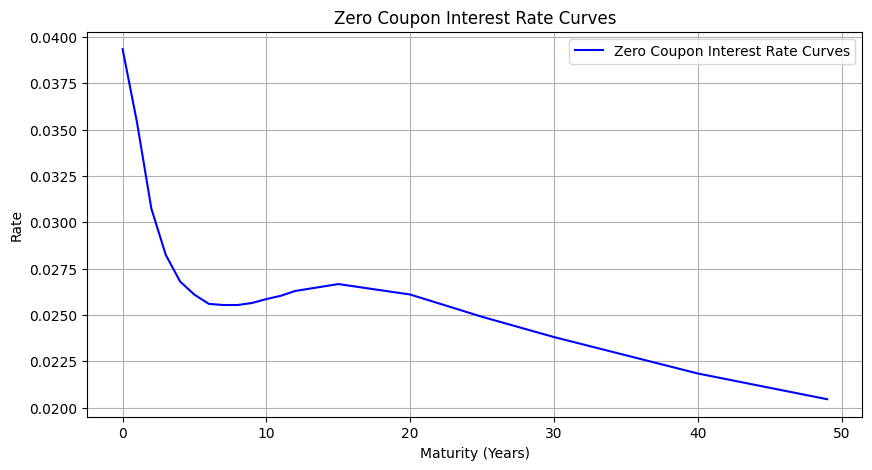

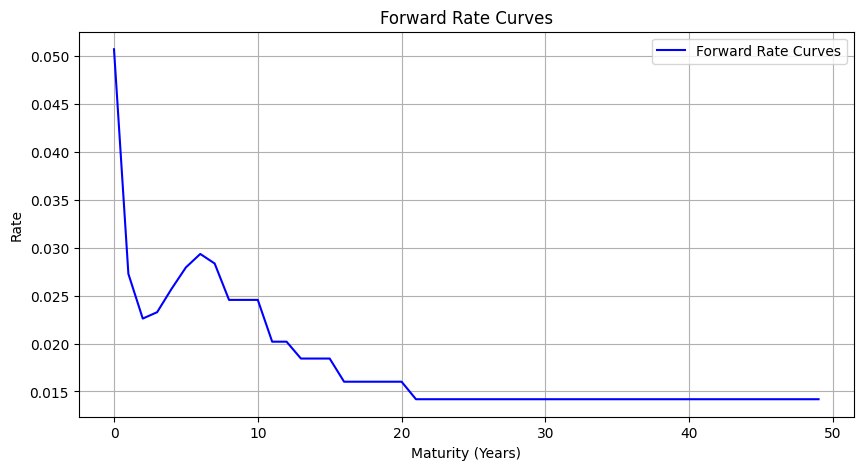

Monte Carlo Swap payer 5y/10y with strike = 0.015
Underlying Swap price : 0.06302331
Underlying Swap's floating leg PV : 0.20375553
Underlying Swap's fixed leg PV : 0.13195029
Strike for Swap price = 0 : 0.02701962
Swaption price : 0.06302331 95% Confidence Interval: [0.0630, 0.0630]
***---------------------------------------------------------------------------------------------------------------------------------------------------------------***
Monte Carlo Swap CMS payer 5y with constant maturity swap rate = 10y, fixing dates = [1, 2, 3, 4, 5]y and strike = 0.015
CMS leg PV : 0.08298275
Fixed leg PV : 0.70761820
CMS price : 0.62463545 95% Confidence Interval: [0.6207, 0.6286]


In [ ]:
### Get the market rates and corresponding zero coupon rates and discount factors.
deposit_market = [
    (1/365, 0.03899), (7/365, 0.03904), (14/365, 0.03903), (1/12, 0.03907), (1/6, 0.03908), (0.25, 0.03888), (1/3, 0.03853),
    (5/12, 0.03803), (0.5, 0.03762), (7/12, 0.03716), (2/3, 0.03661), (0.75, 0.03618), (5/6, 0.03562), (11/12, 0.03510), (1, 0.03479),
    ]

swap_market = [
    (1.5, 0.03208), (2, 0.03023), (3, 0.02787), (4, 0.02650), (5, 0.02582), (6, 0.02535), (7, 0.02528), (8, 0.02527), (9, 0.02536),
    (10, 0.02554), (11, 0.02569), (12, 0.02591), (15, 0.02635), (20, 0.02614), (25, 0.02531), (30, 0.02452), (40, 0.02322), (50, 0.02214),
    ]

zc_curve = zc_curve(deposit_market, swap_market)
plot_curve(zc_curve.maturities, zc_curve.zc_rates_interp, 'Zero Coupon Interest Rate Curves')


# LMM specs used to simulate
fwd_tenor = 0.5    # forward's tenor, e.g. 0.25 for a forward 3M

# Swaption specs to price
swap_tenor = 10   # underlying swap's tenor
expiry = 5        # option's maturity
strike = 0.015

# CMS specs to price
cms_swap_ref = 10   # maturity of the swap of reference 
pay_lag_periods = 2 # number of periods (i.e. number of tenors of the underlying swap) between fixing and payment date
fixing_times = [1, 2, 3, 4, 5] # fixing times

payer_receiver = 'payer'

### Calculate the underlying swap rate
swap = swap(payer_receiver, expiry, swap_tenor, fwd_tenor)
swap.forward_swap_rate(zc_curve.df)

### Calibrate the Libor Market Model
lmm = libor_market_model(swap)
lmm.forward_curve(zc_curve.df)
L0 = lmm.forward_rates
plot_curve(lmm.maturities, lmm.forward_rates_interp, 'Forward Rate Curves')

a, b, c = 0.3, 0.1, 0.05
lmm.volatility_structure(a, b, c)

beta = 0.1
lmm.correlation_factors(beta)

### Calculate the price of a swaption and CMS swap with the Libor Market Model, using the Monte Carlo method.
Nsimul = 40000
batch_size = 2000

steps_per_year = 12
Nsteps = max(1, int(round(expiry * steps_per_year)))
dt = expiry / Nsteps

# Generate MC simulations and price a swaption
lmm_swaption_mc = libor_market_model_swaption_mc(Nsteps, Nsimul, batch_size, L0, swap, lmm, zc_curve, strike, dt)
lmm_swaption_mc.compute_price_swaption()

# Generate MC simulations and price a CMS swap
lmm_cms_mc = libor_market_model_cms_mc(Nsimul, batch_size, cms_swap_ref, fixing_times, pay_lag_periods, L0, swap, lmm, zc_curve, strike)
lmm_cms_mc.compute_price_cms()

